# Seeking the perfect neighborhood to open a new Mediterranean restaurant in Los Angeles

This notebook is intended to help the client Mr. Alexopoulos in the search for an ideal neighborhood to open his new Mediterranean restaurant.

In [ ]:
# Loading up all needed libraries

import pandas as pd
try: import geocoder
except: 
  !pip install geocoder
  import geocoder
import requests
import folium
import numpy as np
from bs4 import BeautifulSoup

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [ ]:
# API KEYS
# /!\ TO BE HIDDEN
BING_MAPS_API_KEY = 'AplejZ12GmDCmsX9xcxWswLG911zp49HD-6i2L_5z_geIVz8QXmGRNmOBRyBVUYg'
FOURSQUARE_API_KEY = 'fsq3MYRMDdtJwWf6mQdgOSh1RLQUXugAdYQ/K3/yygILE8Y='

## Stage #1

### Scraping the web
Import the data from the Wikipedia table at https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

I use `pd.read_html` to transform the HTML table into a dataframe.
**The** content of each cell is then transferred to the mapping function `getCellData` that splits the postal code, the borough and the neighbourhood name. An intermediate list (array) of dictionaries is used to create the final dataframe.

The dataframe is then cleaned by getting rid of the rows that contain undefined boroughs. 

In [ ]:
# We setart with an empty dataframe
df = pd.DataFrame()

# Start by scraping wikipedia
# Each neighborhood is grouped after the 2nd to 5th header 2, each inside
# a list bullet. Taking advantage of that, I only need to take the text of 
# the first link (a) element of each bullet.
soup = requests.get("https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles")
soup = BeautifulSoup(soup.text, features='html.parser')
n = []
for h2 in soup.find_all('h2')[1:5]:
  div = h2.find_next_sibling('div')
  try: 
    lis = div.find_all('li')
    for li in lis:
      a = li.find('a')
      n.append(a.text)
  except: print("")

df['Neighborhood'] = n
print(df.shape)

df.head()

(220, 1)


,Neighborhood
0,Adams-Normandie
1,Alsace
2,Angelino Heights
3,Angeles Mesa
4,Angelus Vista


### Geolocating the neighborhoods

We use the geolocation package with the services from OpenStreetMap, bing, and arcGIS to define the location of the center of each neighborhood.

In [ ]:
# Seems right; I count 220 entries in the Wikipedia list.
# Now I will geolocate the "geographical centroids" of each one.
lat = []
lon = []
df['lat'] = None
df['lon'] = None
for i in range(0, df.shape[0]):
  try:
    g = geocoder.osm("{}, Los Ángeles, California, United States".format(df.iloc[i]['Neighborhood']))
    test = g.latlng[0]
    latlon = g.latlng
  except:
    latlon = [None, None]
  lat.append(latlon[0])
  lon.append(latlon[1])

df['lat'] = lat
df['lon'] = lon

df.head()

,Neighborhood,lat,lon,segment,cluster,_dist_
0,Adams-Normandie,34.031788,-118.300247,0,1,94019.769491
1,Alsace,34.042733,-118.351096,0,1,94714.849048
2,Angelino Heights,34.070289,-118.254796,0,2,39040.703566
3,Angeles Mesa,33.991402,-118.319520,0,1,225166.002701
5,Arlington Heights,34.043494,-118.321374,0,2,56020.784378


In [ ]:
# I save the current dataframe in order to use it in later sessions and 
# not needing to make unnecessary API calls
#df.to_json('./drive/MyDrive/$TMP/df.v1.json')

# To load old data:
df = pd.read_json('./drive/MyDrive/$TMP/df.v1.json')

In [ ]:
# Some gecodes were not right because the neighborhoods are "old"
# We remove them
df.dropna(inplace=True)
print(df.shape)
df.head()

(197, 4)


,Neighborhood,lat,lon,segment
0,Adams-Normandie,34.031788,-118.300247,0
1,Alsace,34.042733,-118.351096,0
2,Angelino Heights,34.070289,-118.254796,0
3,Angeles Mesa,33.991402,-118.319520,0
5,Arleta,34.241327,-118.432205,0


In [ ]:
# Let's see the neighborhoods in a map:
color_groups = ['black', 'red', 'blue', 'yellow', 'green', 'purple', 'orange', 'pink', 'olive', 'grey'] # For later use

# I use a similar function to the one described along the course for mapping
# neighborhood centers but also categories encoded in color
def do_map(df):
  max_lat = -1000; min_lat = 1000; max_lon = -1000; min_lon = 1000;
  for lat, lon in zip(df['lat'], df['lon']):
    max_lat = max(max_lat, lat)
    min_lat = min(min_lat, lat)
    max_lon = max(max_lon, lon)
    min_lon = min(min_lon, lon)

  map = folium.Map(location=[(max_lat+min_lat)/2, (max_lon+min_lon)/2], zoom_start=11)
  for lat, lng, label, cat in zip( \
    df['lat'], \
    df['lon'], \
    df['Neighborhood'], \
    df['cluster'] ):
      label = folium.Popup(label + ' ('+str(cat)+')', parse_html=True)
      folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=color_groups[cat],
        fill=True,
        fill_color=color_groups[cat],
        fill_opacity=0.4,
        parse_html=False).add_to(map)
  return map

In [ ]:
# I add the column category to the dataeset
df['cluster'] = 0
do_map(df)

## Stage 2

### FourSquare places extraction

We set up the FourSquare API to request the info of the places to carry out the rest of the study.

In [ ]:
# Function to ease queries to the FourSquare API
# Note this is for FourSquare API v3, and needs the API key sent via header 
# instead of user id and user secret sent via GET parameter.
def foursquare_request(endp, id, query={}):
  url = 'https://api.foursquare.com/v3/'+endp+'/'+id+'?'
  for k, v in query.items(): url += str(k)+'='+str(v)+'&'
  url = url[:-1]
  r = requests.get(url, headers={\
    "accept": "application/json", 
    "Authorization": FOURSQUARE_API_KEY} )
  return r.json()['results']

# I will store requested data in my local drive in order to reduce
# future identical requests to the API
from os.path import exists
import json
def cache_foursquare_request(endp, id, query):
  fname = 'FOURSQUARE$'+endp+'-'+id+'?'
  for k, v in query.items(): fname += '&'+str(k)+'='+str(v)
  fname = './drive/MyDrive/$TMP/'+fname
  if exists(fname):
    #print("From file")
    with open(fname) as f:
      data = json.load(f)
  else:
    #print("From API & to file")
    data = foursquare_request(endp, id, query)
    with open(fname, 'w') as outfile:
      json.dump(data, outfile)

  return data

In [ ]:
# Now we will extract the closest(up to 50) nearby(a diameter of 1.5 km) places from FourSquare
results = {}
for n, lat, lon in zip(df['Neighborhood'], df['lat'], df['lon']):
  results[n] = cache_foursquare_request('places', 'search', {\
    'll': "{},{}".format(lat,lon), \
    'radius': 750, \
    'limit': 50
  })

The purpose of the following code cells is to make the categories more comprehensive

In [ ]:
# We will do some work regarding places categorization management
# The categories and grouping of them can be found in 
# https://developer.foursquare.com/docs/categories

cat_conv = pd.read_csv('https://raw.githubusercontent.com/Factual/places/master/categories/utils/Foursquare_to_NAICS_and_SIC.tsv', sep="\t")
cat_conv.drop(axis=1, labels=['naics_code', 'naics_label', 'sic_code', 'sic_label'], inplace=True)

# Now, I want to define with more precision some categories
detail = [ \
  {'match': ['> Cosmetics Store', '> Fashion Retail'], 'add': 1, 'title': 'Fashion stores'}, 
  {'match': ['> Food and Beverage Retail', '> Drugstore'], 'add': 2, 'title': 'Basic provision shops'}, 
  {'match': ['> Art Gallery', '> Performing Arts Venue', '> Museum', '> Movie Theater', '> Planetarium', '> Aquarium', '> Zoo'], 'add': 3, 'title': 'Cultural leissure'},
  {'match': ['> Health and Beauty Service'], 'add': 4, 'title': 'Health & beauty'}
]
j0 = 0;
for i, row in cat_conv.iterrows():
  if row['foursquare_category_id'] % 1000 == 0:
    j0 = row['foursquare_category_id']
    t0 = row['foursquare_category_label']
  cat_conv.loc[i, 'category_id'] = j0
  cat_conv.loc[i, 'category_title'] = t0
  for de in detail:
    test = any(list(map(lambda x: x in row['foursquare_category_label'], de['match'])))
    if test:
      cat_conv.loc[i, 'category_id'   ] = j0 + de['add']
      cat_conv.loc[i, 'category_title'] = de['title']

def convert_categories(cats):
  r = []
  for cat in cats:
    r.append(cat_conv[cat_conv['foursquare_category_id']==cat['id']]['category_id'].values[0])
  return list(set(r))
 
cat_conv['category_id'] = cat_conv['category_id'].astype(int)
cat_conv.head()

,foursquare_category_id,foursquare_category_label,category_id,category_title
0,10000,Arts and Entertainment,10000,Arts and Entertainment
1,10001,Arts and Entertainment > Amusement Park,10000,Arts and Entertainment
2,10002,Arts and Entertainment > Aquarium,10003,Cultural leissure
3,10003,Arts and Entertainment > Arcade,10000,Arts and Entertainment
4,10004,Arts and Entertainment > Art Gallery,10003,Cultural leissure


In [ ]:
# Now we create a dataframe with the unique category_id and category_title for later use
cat_conv_simple = pd.DataFrame()
cat_conv_simple['category_id']    = list(pd.unique(cat_conv['category_id']))
cat_conv_simple['category_title'] = list(pd.unique(cat_conv['category_title']))

ccs = {}
for i, row in cat_conv_simple.iterrows(): ccs[row['category_id']] = row['category_title']
cat_conv = None
cat_conv_simple

,category_id,category_title
0,10000,Arts and Entertainment
1,10003,Cultural leissure
2,11000,Business and Professional Services
3,11004,Health & beauty
4,12000,Community and Government
5,13000,Dining and Drinking
6,14000,Event
7,15000,Health and Medicine
8,16000,Landmarks and Outdoors
9,17000,Retail


In [ ]:
places = {}
# 1st pass.
# Assign each place a single neighborhood depending on its distance to the 
# search origin; also, set the unique identificators for the place category
for neighborhood in results.keys():
  for r in results[neighborhood]:
    place = { \
      'id': r['fsq_id'], \
      'categories': convert_categories(r['categories']), \
      'name': r['name'], \
      'dist': r['distance'], \
      'neighborhood': neighborhood \
    }
    try:
      place_old = places[r['fsq_id']] # Error/exception if it does not exists
      # Select the closest neighborhood
      # Prevent that two places are assigned to the same neighborhood
      if place_old['dist'] < place['dist']: place = place_old
    except:
      places[place['id']] = place

# I can free memory now
results = None

In [ ]:
# Well, now let's account for each neighborhood categories total
nhb_categories = {}

for nhb in df['Neighborhood']: 
  nhb_categories[nhb] = {'Neighborhood': nhb}
  for c in cat_conv_simple['category_title']: nhb_categories[nhb][c] = 0

for place in places.values():
  nhb = place['neighborhood']
  for c in place['categories']:
    nhb_categories[nhb][ccs[c]] += 1

# Now, we can merge the two dataframes
df = df.merge(pd.DataFrame(nhb_categories.values()), on='Neighborhood')
nhb_categories = None # Free memory
df

,Neighborhood,Arts and Entertainment,Cultural leissure,Business and Professional Services,Health & beauty,Community and Government,Dining and Drinking,Event,Health and Medicine,Landmarks and Outdoors,Retail,Fashion stores,Basic provision shops,Sports and Recreation,Travel and Transportation
0,Adams-Normandie,1,0,12,6,0,11,0,0,4,3,1,5,3,0
1,Alsace,3,0,13,7,1,11,0,2,0,10,0,5,0,1
2,Angelino Heights,3,3,3,3,0,22,2,0,6,3,3,2,1,1
3,Angeles Mesa,1,0,13,13,3,7,0,0,2,4,0,4,2,0
4,Arleta,0,0,23,5,1,5,1,0,1,10,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Wilshire Park,2,0,6,3,0,17,0,0,1,5,3,3,2,0
193,Wilshire Vista,0,0,9,12,2,9,0,1,2,4,1,3,0,0
194,Windsor Square,1,0,3,4,0,1,0,0,3,2,5,0,0,0
195,Winnetka,0,1,19,4,0,16,0,0,2,8,0,2,0,0


##Stage #3

For the next stage, we will prepare the categories count per neighbour as the fitting data for the clustering algorithms

In [ ]:
# We will make segmentation with the data from the places 
# It is advisable to normalize results
# Here, the importance relies on the proportion of each type of business, so the normalization
# is donde in each neighborhood
X1 = df[ list(ccs.values()) ]

for i, row in X1.iterrows():
  total = 0
  for j in row.values: total += j
  for c in X1.columns: X1.loc[i, c] = X1.loc[i, c]/(total+0.00001)

# It can now be done in columns
# X2 = X1.copy()
# for c in list(ccs.values()): X2[c] = X1[c].values/max(X1[c].values)
# /!\ Finally I did not use this X2, since it makes less sense than X1

X1.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Arts and Entertainment,Cultural leissure,Business and Professional Services,Health & beauty,Community and Government,Dining and Drinking,Event,Health and Medicine,Landmarks and Outdoors,Retail,Fashion stores,Basic provision shops,Sports and Recreation,Travel and Transportation
0,0.021739,0.000000,0.260870,0.130435,0.000000,0.239130,0.000000,0.000000,0.086957,0.065217,0.021739,0.108696,0.065217,0.000000
1,0.056604,0.000000,0.245283,0.132075,0.018868,0.207547,0.000000,0.037736,0.000000,0.188679,0.000000,0.094340,0.000000,0.018868
2,0.057692,0.057692,0.057692,0.057692,0.000000,0.423077,0.038462,0.000000,0.115385,0.057692,0.057692,0.038462,0.019231,0.019231
3,0.020408,0.000000,0.265306,0.265306,0.061224,0.142857,0.000000,0.000000,0.040816,0.081633,0.000000,0.081633,0.040816,0.000000
4,0.000000,0.000000,0.479167,0.104167,0.020833,0.104167,0.020833,0.000000,0.020833,0.208333,0.000000,0.020833,0.000000,0.020833


First try: DBSCAN clustering

I did not achieve convincing results

In [ ]:
# We perform the DBSCAN clustering
dbclusters = DBSCAN(eps=.2, min_samples=10).fit(X1)
print(len(dbclusters.labels_))
print(dbclusters.labels_)

df['cluster'] = dbclusters.labels_ + 1
do_map(df)

197
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0]


Next I try is K-means clustering method. I go from 2 to 6 clusters to see the grouping results.

In [ ]:
ncs = pd.DataFrame(columns=['N. kclusters'])
maxkclusters = 7 #6, actually
for k in range(1,maxkclusters): ncs['C.'+str(k)] = None
for kclusters in range(2,maxkclusters):
  row = {'N. kclusters': kclusters}
  kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X1)
  for k in range(0,maxkclusters): 
    if k < kclusters: row['C.'+str(k+1)] = int(sum(map(lambda x: x==k, kmeans.labels_ )))
    else:             row['C.'+str(k+1)] = "- -"
  ncs = ncs.append(row, ignore_index=True)

ncs

,N. kclusters,C.1,C.2,C.3,C.4,C.5,C.6,C.7
0,2,67,130,- -,- -,- -,- -,- -
1,3,75,85,37,- -,- -,- -,- -
2,4,83,68,13,33,- -,- -,- -
3,5,83,75,37,1,1,- -,- -
4,6,66,31,28,59,12,1,- -


I find the best number of clusters is 3 or 4, as 5 and 6 create clusters with very few (1) neighborhood.

In [ ]:
# We perform the k-means clustering with the tuned parameter
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X1)
kmeans.labels_[0:10]

# Now, we add kmeans.labels_ to the main dataframe
# We need to add one to kmeans.labels_ for map plotting
df['cluster'] = kmeans.labels_ + 1
do_map(df)

The next step is finding out what each cluster have in common. This is the most funny part of evaluating the results of an unsupervised algorithm 😀

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

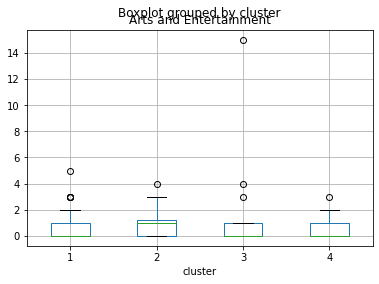

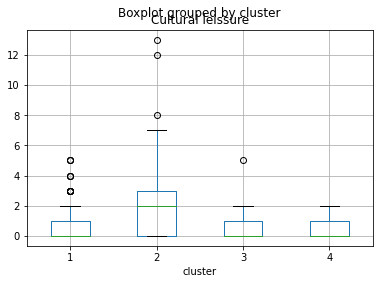

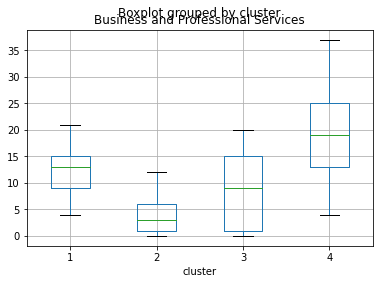

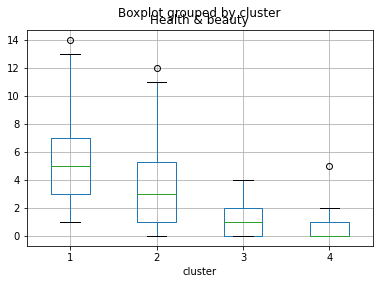

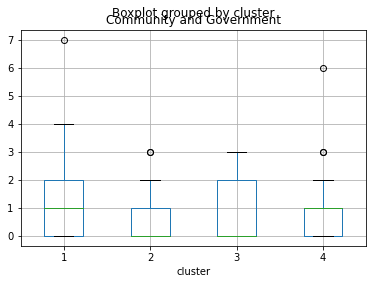

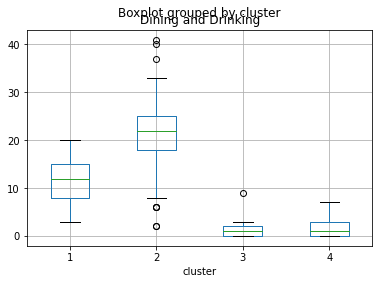

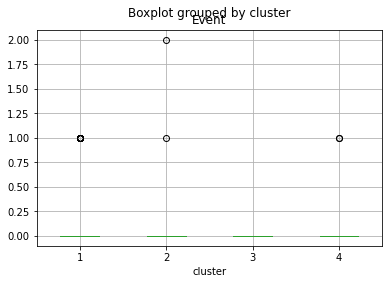

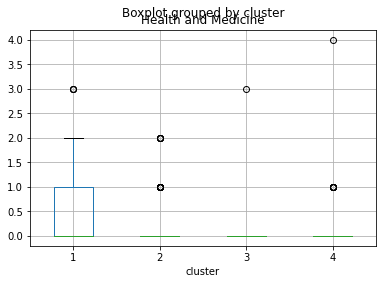

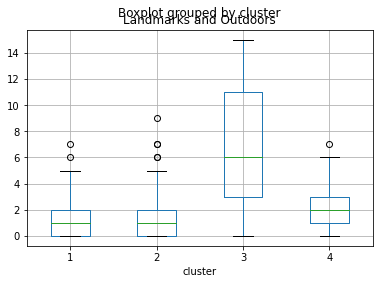

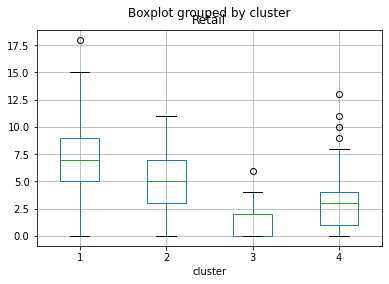

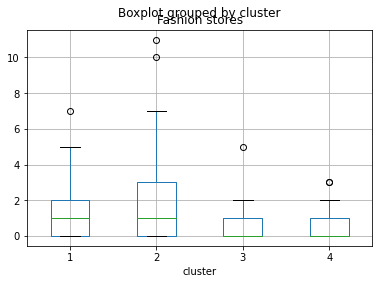

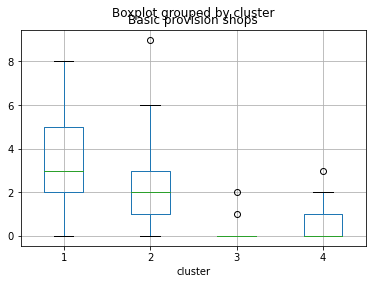

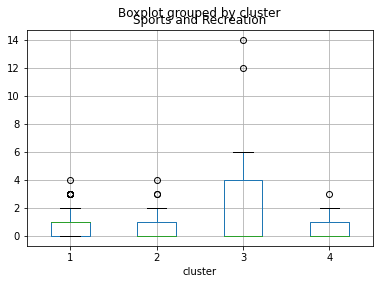

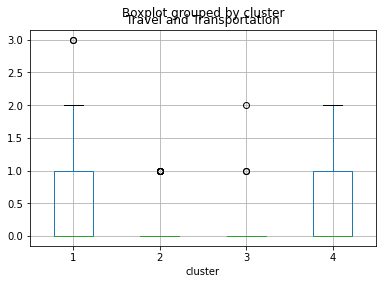

In [ ]:
# We will visualize the results with matplotlib using box plots
import matplotlib.pyplot as plt

for col in list(ccs.values()):
  bp = df.boxplot(by ='cluster', column=col)
  bp.figure.savefig("./drive/MyDrive/$TMP/boxplot_{}.svg".format(col), format="svg")
  bp

Results reveal that cluster 1 is of residential neighborhoods, and cluster 2 is of mainly touristic ones, where most of the restaurant business are located.

The final step is to filter the clusters to those that are closer to residential neighborhoods.

In [ ]:
# Haversine formula for the distance between two lat,lon points on Earth
from math import acos, sin, cos, pi
def dist(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(lambda x: x*pi/180, [lon1, lat1, lon2, lat2])
    return 6371000 * acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))

dff = df.copy()
# Drop clusters 3 and 4
dff.drop(index=dff[dff['cluster']==3].index, axis=0, inplace=True)
dff.drop(index=dff[dff['cluster']==4].index, axis=0, inplace=True)
#dff.drop(labels=list(pd.unique(cat_conv['category_title'])), axis=1, inplace=True)
dff['_dist_'] = 10000

for i, row in dff.iterrows():
  lat = row['lat']
  lon = row['lon']
  if (row['cluster'] == 2):
    d = min(map(lambda x: dist(lat, lon, x[0], x[1]), dff[dff['cluster']==1][['lat', 'lon']].values))
  else:
    d = min(map(lambda x: dist(lat, lon, x[0], x[1]), dff[dff['cluster']==2][['lat', 'lon']].values))
  dff.loc[i,'_dist_'] = d

dff['cluster'] = (dff['cluster']).values * list(map(lambda x: 0 if x else 1, (dff['_dist_']<1000))) + list(map(lambda x: 5 if x else 0, (dff['_dist_']<1000)))

In [ ]:
do_map(dff)